In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit
import scipy.optimize as opt

import tables
import os

test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

63734


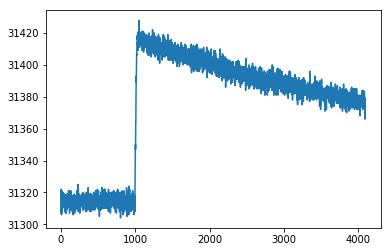

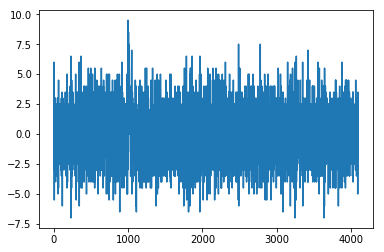

In [44]:
h5file = tables.open_file("test_input.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData
print(len(EventData))



plt.figure()
plt.plot(data[100,:])
plt.figure()
plt.plot(np.gradient(data[100,:]))
plt.show()

In [ ]:
h5file2 = tables.open_file("cs137_co60.h5", driver="H5FD_CORE")
print(h5file2)
data_CsCo = h5file2.root.RawData
EventData_CsCo = h5file2.root.EventData
print(len(EventData))



plt.figure()
plt.plot(data[100,:])
plt.figure()
plt.plot(np.gradient(data[100,:]))
plt.show()

In [45]:
# Find pulses that triggered multiple times and delete them
i_pileup = 0
j_pileup = 0
pileup_args = np.array([])
EventDataArray = np.array(EventData)

for x in range(len(EventData)):
    if int(EventData[x][3])>1:
        pileup_args = np.append(pileup_args,i_pileup)
        j_pileup = j_pileup+1  
    i_pileup = i_pileup+1

print(data)
print(len(pileup_args))

data = np.delete(data[:], pileup_args, 0)
    
print('deleted ', len(pileup_args),' signals due to pile up')
#print(len(data2))

/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''
1248


/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


deleted  1248  signals due to pile up


In [46]:
@jit(parallel = True)
def baseLineReduction(mysignal):
    avgNoise = np.mean(mysignal[0:1000])
    return mysignal-avgNoise

In [47]:
@jit(parallel = True)
def TrapFilter(mysignal,tau,k,m):
    signalOnly = baseLineReduction(mysignal) 
    M = tau
    Acc1=0.0
    Acc2=0.0
    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    final = np.zeros(len(signalOnly))
    for i in range(len(signalOnly)):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)
    return normFinal

In [48]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals = makesignals(data)

print(datetime.now() - startTime)

62486
0:00:02.590580


In [49]:
@jit(parallel = True)
def func(x, a, b):
    return a * np.exp(-b * x)

In [50]:
#startTime = datetime.now()
#events = len(mysignals)
#cols = len(data[0,:])
#trap_out = np.zeros((events,cols))
#tau = np.zeros(events)
#for j in range(0,events):
#    signalOnly = baseLineReduction(mysignals[j])
#    popt, pcov = curve_fit(func, range(0,len(signalOnly)-1115), signalOnly[1115:])
#    tau[j] = 1.0/popt[1]
#    print(j)
#print('Average Tau across all signals',np.mean(tau))
#print(datetime.now() - startTime)

In [51]:
@jit(parallel = True)
def eventsProcess(mysignals, events, cols,tau,k,m):
#    tau = np.zeros(events)
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in range(0,events):
        trap_out[j] = TrapFilter(mysignals[j,:],tau,k,m)
    print(datetime.now() - startTime)
    return trap_out

In [52]:
@jit(parallel = True)
def gauss(x, a, u, sig): # p[0]==mean, p[1]==stdev
#    return 1.0/(sig*np.sqrt(2.0*np.pi))*np.exp(-(x-u)**2.0/(2.0*sig**2.0))
    return a*np.exp(-(x-u)**2.0/(2.0*sig**2.0))

@jit(parallel = True)
def FWHM(counts,lower_bound,upper_bound):
    X = range(lower_bound, upper_bound)
    Y = counts[lower_bound:upper_bound]
    # Fit a guassian
#    p0 = [5590,20] # Inital guess is a normal distribution
#    errfunc = lambda p, x, y: gauss(x, p) - y # Distance to the target function
#    p1, success = opt.leastsq(errfunc, p0[:], args=(X, counts[lower_bound:upper_bound]))
#    print(success)
    mean = sum(X * Y) / sum(Y)
    sigma = np.sqrt(sum(Y * (X - mean)**2) / sum(Y))
    print(sigma)
    pi = [max(Y), mean,sigma]
    popt, pcov = curve_fit(gauss, X, Y, p0=pi)
    print(popt)
    fit_a, fit_mu, fit_stdev = popt
#    plt.plot(X,gauss(X,*popt),'r')
#    plt.bar(X,Y, width=1.0)
#    plt.xlim(5540,5650)

    return 2*np.sqrt(2*np.log(2))*np.abs(fit_stdev)

In [53]:
@jit(parallel = True)
def TraptoCounts(trap_out,k,M):
    counts = []
    for j in range(0,len(trap_out)):
        counts = np.append(counts,np.amax(trap_out[j]))
    counts2 = np.trim_zeros(counts)
    counts2 = counts2/((M+1)*k)
    counts3 = counts2[(counts2>0) & (counts2<1e3)]
    yhist, bins_hist = np.histogram(counts3,bins=8196)
    return yhist

# convert Traps to Counts and then do FWHM on the Peak
#plt.figure()
#nhist, bins, ign = plt.hist(counts3,bins=8196)

In [ ]:
print(len(mysignals))
events = len(mysignals)
tau = 5810.79

@jit(parallel = True)
def find_m(mysignals,events,cols,tau,k):
    out = [range(100)]
    for m in range(100):
        processedEvents = eventsProcess(mysignals,events,cols,tau,k,m)
        counts = TraptoCounts(processedEvents,k,tau)
        out.append(FWHM(counts,4300,4600))
        print('m=',m)
    return final

@jit(parallel = True)
def find_k(mysignals, events, cols, tau, m):
    out = []
    for k in range(200,1200,20):
        processedEvents = eventsProcess(mysignals,events,cols,tau,k,m)
        counts = TraptoCounts(processedEvents,k,tau)
        out.append(FWHM(counts,4300,4600))
        print('k=',k)
    return out

startTime = datetime.now()
#find k first
FWHM_k = find_k(mysignals,events,cols,tau,32)

print(datetime.now() - startTime)

62486
0:00:18.797657
82.27070137058536
[   4.66630463 4397.79928087  179.76300428]
k= 200
0:00:15.984351
83.05749485286394
[   4.63342282 4385.68217137  199.39233466]
k= 220
0:00:13.013833
83.09012758915728
[   4.62932498 4382.25026084  202.64618944]
k= 240
0:00:12.368961
83.2635028203586
[   4.60600376 4381.70660251  206.83314483]
k= 260
0:00:11.993868
83.32883097336324
[   4.60192103 4378.57385006  209.85538029]
k= 280
0:00:11.921392
83.06407166033704
[   4.61168895 4380.48726749  203.75683274]
k= 300
0:00:12.173416
83.08981382203105
[   4.60722783 4379.75666254  204.72062163]
k= 320
0:00:12.415801
83.56138006646935
[   4.61427508 4364.74408994  222.74749154]
k= 340
0:00:12.266447
82.95135964979548
[   4.60930041 4378.52234236  202.42759836]
k= 360
0:00:13.239697
83.15518100518833
[   4.59087441 4380.86259731  204.98283075]
k= 380
0:00:13.461738
83.16855055059291
[   4.5787721  4383.03439297  203.25717232]
k= 400
0:00:12.543627
83.1388904882412
[   4.59990153 4378.48551707  204.67570

In [ ]:
FWHM_m = find_m(mysignals,events,cols,tau,750)